In [33]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.circuit.library import RawFeatureVector, QNNCircuit
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit.quantum_info import SparsePauliOp
import time

from prepare_data import load_data

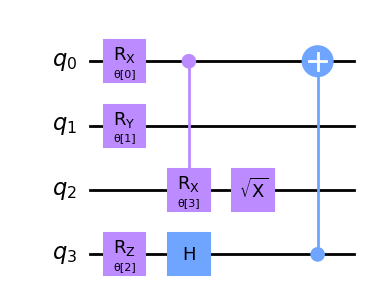

In [2]:
# pytorch quantum demo
def conv_circuit_pytorch_quantum(params):
    target = QuantumCircuit(4)
    target.rx(params[0], 0)
    target.ry(params[1], 1)
    target.rz(params[2], 3)
    target.crx(params[3], 0, 2)
    target.h(3)
    target.sx(2)
    target.cx(3, 0)
    return target

params = ParameterVector("θ", length=4)
circuit = conv_circuit_pytorch_quantum(params)
circuit.draw("mpl", style="clifford")

In [23]:
# Qiskit demo
def conv_circuit_qiskit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit_qiskit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit_qiskit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

def create_circuits_qiskit(num_qubits, keep_pooling=True):
    feature_map = ZFeatureMap(num_qubits)
    qubit_list = list(range(num_qubits))

    ansatz = QuantumCircuit(num_qubits, name="Ansatz")
    ansatz.compose(conv_layer(num_qubits, "c1"), qubit_list, inplace=True)
    if keep_pooling:
        add_pooling_layers(ansatz, num_qubits)
    else:
        ansatz.compose(pool_layer(list(range(0, num_qubits//2)), list(range(num_qubits//2, num_qubits)), "p1"), qubit_list, inplace=True)

    circuit = QuantumCircuit(num_qubits)
    circuit.compose(feature_map, range(num_qubits), inplace=True)
    circuit.compose(ansatz, range(num_qubits), inplace=True)

    circuit.draw("mpl", style="clifford")

    return feature_map, ansatz

def add_pooling_layers(ansatz, num_qubits):
    qubit_count = num_qubits
    count = 1
    while qubit_count > 2 and qubit_count % 2 == 0:
        first_half = list(range(0, qubit_count//2))
        second_half = list(range(qubit_count//2, qubit_count))
        qubit_list = list(range(qubit_count))
        ansatz.compose(pool_layer(first_half, second_half, f"p{count}"), qubit_list, inplace=True)
        count += 1
        if qubit_count % 2 == 0:
            qubit_count = qubit_count // 2
        else:
            break

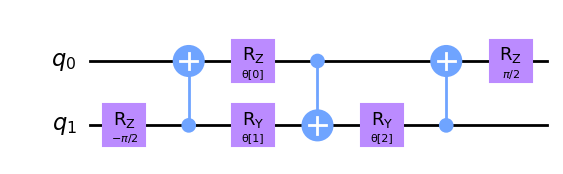

In [4]:
# Convolution Circuit
params = ParameterVector("θ", length=3)
circuit = conv_circuit_qiskit(params)
circuit.draw("mpl", style="clifford")

In [ ]:
# Fully Connected Layer
circuit = conv_layer(10, "θ")
circuit.decompose().draw("mpl", style="clifford")

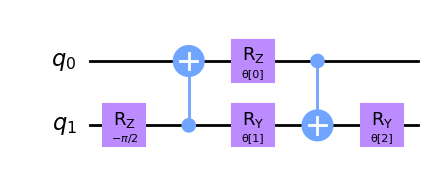

In [6]:
# Pooling Circuit
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

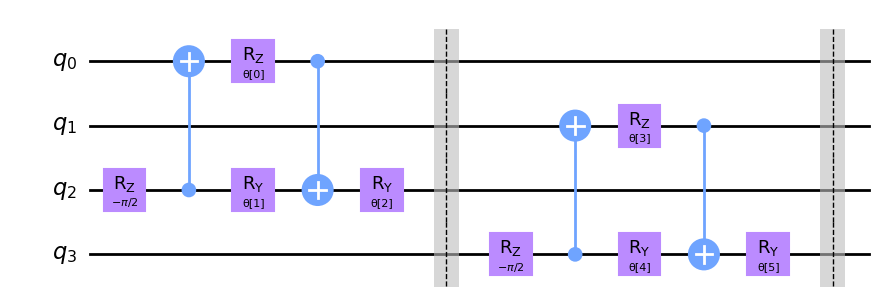

In [17]:
# Pooling Layer
sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [8]:
num_qubits = 16

def callback_method(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)

In [27]:
# Binary labels with EstimatorQNN, single convolution layer + single pooling layer, default max iterations 200
feature_map, ansatz = create_circuits_qiskit(num_qubits, keep_pooling=True)
observable = SparsePauliOp.from_list([("Z" + "I" * (num_qubits-1), 1)])

circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, range(num_qubits), inplace=True)
circuit.compose(ansatz, range(num_qubits), inplace=True)

qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=50),
    callback=callback_method
)

digit1, digit2 = 3, 6
(train_images, train_labels), (test_images, test_labels) = load_data(digits=[digit1, digit2], final_shape=(4, 4), threshold=0.5)
print("Train Shape: ", train_images.shape, train_labels.shape)
print(f"Number of {digit1}: {np.sum(train_labels)}. Number of {digit2}: {train_labels.shape[0] - np.sum(train_labels)}")
print("Test Shape: ", test_images.shape, test_labels.shape)
print(f"Number of {digit1}: {np.sum(test_labels)}. Number of {digit2}: {test_labels.shape[0] - np.sum(test_labels)}\n")

objective_func_vals = []
x = np.array([np.ravel(image) for image in train_images])
y = np.asarray(train_labels)
x_test = np.array([np.ravel(image) for image in test_images])
y_test = np.asarray(test_labels)

start = time.time()

classifier.fit(x, y)

print(f"Train time: {time.time()-start :.2f}s")
print(f"Training Accuracy: {classifier.score(x, y)}")
print(f"Testing Accuracy: {classifier.score(x_test, y_test)}")
print(f"Objective Function Values: {objective_func_vals}")

# circuit.draw("mpl", style="clifford")

Train Shape:  (52, 4, 4, 1) (52,)
Number of 3: 29. Number of 6: 23
Test Shape:  (40, 4, 4, 1) (40,)
Number of 3: 18. Number of 6: 22

Train time: 385.88s
Training Accuracy: 0.5576923076923077
Testing Accuracy: 0.45
Objective Function Values: [0.5377930650888637, 0.5335810550266463, 0.4690299879145626, 0.44922282676799663, 0.44922282676799674, 0.4492228267679966, 0.44922282676799646, 0.44922282676799663, 0.44922282676799646, 0.44922282676799663, 0.4087385443207827, 0.3875332477342267, 0.39977949999944085, 0.40192094550643837, 0.9388366789243336, 0.6346761110206453, 0.3875332477342267, 0.3875332477342266, 0.3875332477342266, 0.38753324773422665, 0.3875332477342264, 0.38753324773422676, 0.3847886647317569, 0.40752382923497205, 0.3877519031836709, 0.384788664731757, 0.38478866473175716, 0.3847886647317571, 0.38478866473175716, 0.38478866473175716, 0.38478866473175705, 0.3847886647317571, 0.38478866473175705, 0.3847886647317571, 0.4070782625435078, 0.3275067143456483, 0.18777402346453756, 0

In [ ]:
"""
Single Epoch 8sec
50 Epoch around 

Single convolution + 1 pooling layer, threshold 0.5
    Data
        Train Shape:  (52, 4, 4, 1) (52,)
        Number of 3: 29. Number of 6: 23
        Test Shape:  (40, 4, 4, 1) (40,)
        Number of 3: 18. Number of 6: 22
    maxiter: 50
    Train time: 379.36s
    Training Accuracy: 0.5576923076923077
    Testing Accuracy: 0.45
    {OBJECTIVE FUNCTION VALUES}

Single convolution + 1 pooling layer, no threshold
    Data
        Train Shape:  (9895, 4, 4, 1) (9895,)
        Number of 3: 4613. Number of 6: 5282
        Test Shape:  (1749, 4, 4, 1) (1749,)
        Number of 3: 850. Number of 6: 899
    maxiter: 50
    too long to train

Single convolution + n pooling layer until binary, threshold 0.5
    Data
        Train Shape:  (52, 4, 4, 1) (52,)
        Number of 3: 29. Number of 6: 23
        Test Shape:  (40, 4, 4, 1) (40,)
        Number of 3: 18. Number of 6: 22
    maxiter: 50
    Train time: 385.88s
    Training Accuracy: 0.5576923076923077
    Testing Accuracy: 0.45
    Objective Function Values: [0.5377930650888637, 0.5335810550266463, 0.4690299879145626, 0.44922282676799663, 0.44922282676799674, 0.4492228267679966, 0.44922282676799646, 0.44922282676799663, 0.44922282676799646, 0.44922282676799663, 0.4087385443207827, 0.3875332477342267, 0.39977949999944085, 0.40192094550643837, 0.9388366789243336, 0.6346761110206453, 0.3875332477342267, 0.3875332477342266, 0.3875332477342266, 0.38753324773422665, 0.3875332477342264, 0.38753324773422676, 0.3847886647317569, 0.40752382923497205, 0.3877519031836709, 0.384788664731757, 0.38478866473175716, 0.3847886647317571, 0.38478866473175716, 0.38478866473175716, 0.38478866473175705, 0.3847886647317571, 0.38478866473175705, 0.3847886647317571, 0.4070782625435078, 0.3275067143456483, 0.18777402346453756, 0.18777402346453723, 0.18777402346453734, 0.18777402346453742, 0.18777402346453737, 0.18777402346453753, 0.18777402346453748, 0.18777402346453725, 0.18777402346453728, 0.18777402346453753, 0.19106368533342566, 0.20410145187062453, 0.2021557291038201, 0.1877740234645375]

Sampler QNN
    Data
        Train Shape:  (75, 4, 4, 1) (75,)
        Test Shape:  (48, 4, 4, 1) (48,)
    maxiter: 1
    Train Shape:  (75, 4, 4, 1) (75,)
    Test Shape:  (48, 4, 4, 1) (48,)
    Train time: 105.50s
    Training Accuracy: 0.06666666666666667
    Testing Accuracy: 0.041666666666666664
    Objective Function Values: [22.37305138178695]

VQC
    Data
        Train Shape:  (75, 4, 4, 1) (75,)
        Test Shape:  (48, 4, 4, 1) (48,)
    maxiter: 1
    Train time: 104.94s
    Training Accuracy: 0.08
    Testing Accuracy: 0.0625
    Objective Function Values: [3.3280033814973713]
"""

In [30]:
# Multiple labels with SamplerQNN, default max iterations 30
output_shape = 10  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
def parity(x):
    return "{:b}".format(x).count("1") % 2

feature_map, ansatz = create_circuits_qiskit(num_qubits)

circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, range(num_qubits), inplace=True)
circuit.compose(ansatz, range(num_qubits), inplace=True)

qnn = SamplerQNN(
    circuit=circuit.decompose(),
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape
)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=1),
    callback=callback_method
)

(train_images, train_labels), (test_images, test_labels) = load_data(final_shape=(4, 4))
print("Train Shape: ", train_images.shape, train_labels.shape)
print("Test Shape: ", test_images.shape, test_labels.shape)

objective_func_vals = []
x = np.array([np.ravel(image) for image in train_images])
y = np.asarray(train_labels)
x_test = np.array([np.ravel(image) for image in test_images])
y_test = np.asarray(test_labels)

start = time.time()

classifier.fit(x, y)

print(f"Train time: {time.time()-start :.2f}s")
print(f"Training Accuracy: {classifier.score(x, y)}")
print(f"Testing Accuracy: {classifier.score(x_test, y_test)}")
print(f"Objective Function Values: {objective_func_vals}")

Train Shape:  (75, 4, 4, 1) (75,)
Test Shape:  (48, 4, 4, 1) (48,)
Train time: 105.50s
Training Accuracy: 0.06666666666666667
Testing Accuracy: 0.041666666666666664
Objective Function Values: [22.37305138178695]


In [31]:
print(classifier.predict(x_test))
print(y_test)

[0 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0
 0 1 0 1 0 1 0 1 0 0 1]
[6 8 2 2 6 2 2 4 8 2 2 4 2 6 6 0 0 6 7 6 6 7 4 8 6 5 0 0 4 3 2 4 9 6 3 7 6
 3 8 6 3 3 6 2 3 8 6 3]


In [34]:
# Multiple labels with VQC, default max iterations 30
feature_map, ansatz = create_circuits_qiskit(num_qubits)

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=1),
    callback=callback_method,
)

(train_images, train_labels), (test_images, test_labels) = load_data(final_shape=(4, 4))
print("Train Shape: ", train_images.shape, train_labels.shape)
print("Test Shape: ", test_images.shape, test_labels.shape)

objective_func_vals = []
x = np.array([np.ravel(image) for image in train_images])
y = np.asarray(train_labels)
x_test = np.array([np.ravel(image) for image in test_images])
y_test = np.asarray(test_labels)

start = time.time()

vqc.fit(x, y)

print(f"Train time: {time.time()-start :.2f}s")
print(f"Training Accuracy: {vqc.score(x, y)}")
print(f"Testing Accuracy: {vqc.score(x_test, y_test)}")
print(f"Objective Function Values: {objective_func_vals}")

Train Shape:  (75, 4, 4, 1) (75,)
Test Shape:  (48, 4, 4, 1) (48,)
Train time: 104.94s
Training Accuracy: 0.08
Testing Accuracy: 0.0625
Objective Function Values: [3.3280033814973713]


In [35]:
print(vqc.predict(x_test))
print(y_test)

[5 9 0 6 0 7 2 9 7 1 0 8 0 7 7 8 1 2 9 9 7 7 9 4 3 0 4 0 7 4 7 8 5 2 7 5 8
 0 6 7 0 6 7 5 0 0 9 7]
[6 8 2 2 6 2 2 4 8 2 2 4 2 6 6 0 0 6 7 6 6 7 4 8 6 5 0 0 4 3 2 4 9 6 3 7 6
 3 8 6 3 3 6 2 3 8 6 3]
